#   Data Preparation

In [55]:
import numpy as np
import re, torch
import matplotlib.pyplot as plt

## 1. Data Collection

In [20]:
def read_files(french_file, english_file):
    with open(french_file, 'r', encoding='utf-8') as f_fr, open(english_file, 'r', encoding='utf-8') as f_en:
        fr_sentences = f_fr.readlines()     # Store the sentences into variables
        en_sentences = f_en.readlines()
        
    return fr_sentences, en_sentences

In [21]:
fr, en = read_files('wikimedia.en-fr.fr', 'wikimedia.en-fr.en')

## 2. Data exploration

### 1) Basic Statistics

#### Average Length

We'll start by examining its basic characteristics like the average sentence length.

In [42]:
def basic_stats(sentences):
    num_sentences = len(sentences)      # Count
    total_length = sum(len(sentence.split()) for sentence in sentences)
    avg_length = total_length / num_sentences   # Average length
    
    return num_sentences, avg_length

In [43]:
num_french, avg_len_fr = basic_stats(fr)
num_english, avg_len_en = basic_stats(en)

print(f"French: {num_french} sentences, Average length: {avg_len_fr:.1f} words")
print(f"English: {num_english} sentences, Average length: {avg_len_en:.1f} words")

French: 1446495 sentences, Average length: 27.7 words
English: 1446495 sentences, Average length: 25.5 words


#### Distribution

We will plot a bar chart showing the distribution of the sentences length of both languages.

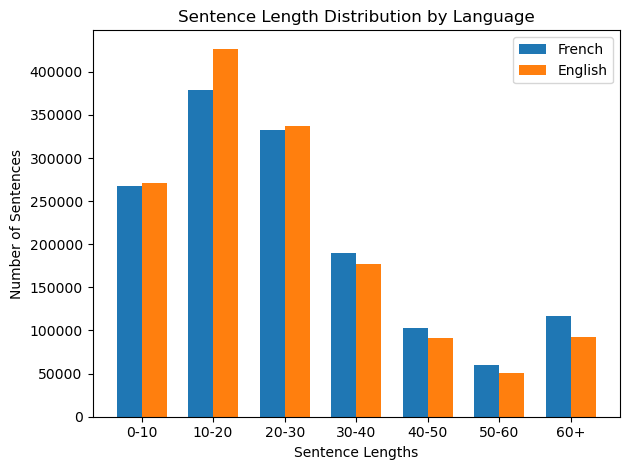

In [44]:
def dist(sentences, bins):
    lengths = [len(sentence.split()) for sentence in sentences]
    distribution = np.histogram(lengths, bins=bins)[0]  
    return distribution

bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']

fr_dist = dist(fr, bins)    # Generate the distribution of French with inpu sentences and bins
en_dist = dist(en, bins)

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fr_dist, width, label='French')    # Plot the barchart
rects2 = ax.bar(x + width/2, en_dist, width, label='English')

ax.set_xlabel('Sentence Lengths')
ax.set_ylabel('Number of Sentences')
ax.set_title('Sentence Length Distribution by Language')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

### 2) Sentence Alignment Check

A simple way to check the alignment is to compare sentence lengths and look for significant discrepancies. 

Based on computational linguistics "French needed ~20% more words to express the same idea as an English text."(see source below),

we can conservatively assume the discrepancy ratio to be 0.5, meaning either the English or the French sentences have a 50% gap in lengths,

Mark Liberman. (2022, May 28). Comparing phrase lengths in French and English. Computational linguistics, Orthography. https://languagelog.ldc.upenn.edu/nll/?p=54806

In [34]:
def sa_check(fr_sentences, en_sentences, threshold=0.5):
    misaligned = 0
    examples = []
    for fr, en in zip(fr_sentences, en_sentences):
        fr_len = len(fr.split())
        en_len = len(en.split())
        if fr_len == 0 or en_len == 0:
            continue
        ratio = round(abs(fr_len - en_len) / min(fr_len, en_len),2)     # Calculate the variation percentage
        if ratio > threshold:
            misaligned += 1
            examples.append((ratio, fr, en))
    print(f"Potential misalignments: {misaligned} out of {len(fr_sentences)} sentences")
    print(f"Percentage: {100 * misaligned/len(fr_sentences):.1f}%")
    
    return examples[:10]    # With some examples

In [45]:
sa_check(fr, en)

Potential misalignments: 191765 out of 1446495 sentences
Percentage: 13.3%


[(1.0, 'Les débuts \n', 'Beginnings \n'),
 (0.82,
  "Le groupe d'origine de Thornhill est composé de douze musiciens, qui jouent tous des instruments traditionnellement utilisés dans le jazz. \n",
  'Thornhill\'s original band comprised twelve musicians, all playing traditionally "jazz" instruments. \n'),
 (0.81,
  "Tom Bacon est considéré comme l'un des fondateurs du cor jazz moderne. Après la mort de Julius Watkins, Tom Bacon reprend son idée de faire entendre le cor dans le monde du jazz. C'est un virtuose qui a commencé sa carrière professionnelle à l'âge de 18 ans avec le Chicago Civic Orchestra. Bien que la plupart des études musicales de Bacon n'aient pas été dans le jazz, il a été inspiré par des grands tels que Duke Ellington et Ella Fitzgerald pour jouer du jazz. \n",
  "Tom Bacon is considered one of the founders of modern jazz horn playing. After Julius Watkins' death, Tom Bacon picked up his idea of having the horn featured in the jazz setting. He is a virtuoso, beginning 

##   3. Data preparation (data cleaning, feature engineering etc)

### 1) Remove Duplicated Rows and misaligned sentences

Duplicated Rows: literally meaning, remove the duplicated rows in each file while keeping them aligned.

Misaligned Sentences: Remove the possible misaligned sentences with discrepancy ratio > 0.5

In [51]:
def data_prep_1(en, fr, c_en_file, c_fr_file, threshold=0.5):
    
    total_pairs_1 = len(en)     # Total rows count before processing

    unique_lines = set()
    unique_pairs = []
    for en_line, fr_line in zip(en, fr):
        if en_line not in unique_lines:
            unique_lines.add(en_line)
            unique_pairs.append((en_line, fr_line))

    total_pairs_2 = len(unique_pairs)       # Total rows count after removing the duplicates

    filtered_pairs = []
    for en_line, fr_line in unique_pairs:
        en_len = len(en_line.split())
        fr_len = len(fr_line.split())
        if en_len == 0 or fr_len == 0:      # 0 can't be divided
            continue
        length_ratio = abs(en_len - fr_len) / min(en_len, fr_len)       # Same method in previous exploration
        if length_ratio <= threshold:
            filtered_pairs.append((en_line, fr_line))

    total_pairs_3 = len(filtered_pairs)     # Total rows count after removing the misaligned rows

 
    with open(c_en_file, 'w', encoding='utf-8') as en_cleaned, open(c_fr_file, 'w', encoding='utf-8') as fr_cleaned:
        for en_line, fr_line in filtered_pairs:
            en_cleaned.write(en_line)       # Write them into files for archiving, 
            fr_cleaned.write(fr_line)

    print(f"Total pairs before removing duplicates {total_pairs_1}")
    print(f"Total pairs after removing duplicates(unique pairs): {total_pairs_2}")
    print(f"Total pairs after filtering: {total_pairs_3}")

In [52]:
data_prep_1(en, fr, 'c1_en.txt', 'c1_fr.txt')       # "c1_en" = clean 1st time English

Total pairs before removing duplicates 1446495
Total pairs after removing duplicates(unique pairs): 1348048
Total pairs after filtering: 1180088


### 2) Normalize Text:
Task 1: Convert all text to lowercase to reduce vocabulary size and complexity. 

Task 2: Remove unnecessary punctuation and special characters that do not contribute to the meaning of the sentences.

The characters allowed for training (Only rows with these characters are allowed to be trained on):
- Normal characters: A-Z, a-z, 

- Special French accents and ligatures: à, â, ç, é, è, ê, ë, î, ï, ô, û, ù, ü, ÿ, ñ, æ (ae ligature), œ (oe ligature). 

- Basic punctuation marks and special characters: space, comma ,, dash -, period ., apostrophe ', parentheses (), quotation marks ", square brackets [], question mark ?, and exclamation mark !. 

In [81]:
def data_prep_2(en, fr, target_en, target_fr):
    allowed_chars = re.compile(r"^[a-z0-9àâçéèêëîïôûùüÿñæœ ,\-.'()\"\[\]?!]+$")     # Only sentences with any characters in the list are allowed to be kept.
    total_pairs_before = 0
    total_pairs_after = 0
    with open(en, 'r', encoding='utf-8') as src_en, \
         open(fr, 'r', encoding='utf-8') as src_fr, \
         open(target_en, 'w', encoding='utf-8') as tgt_en, \
         open(target_fr, 'w', encoding='utf-8') as tgt_fr:

        for line_en, line_fr in zip(src_en, src_fr):
            total_pairs_before += 1         # Calculate the row counts before processing
            if allowed_chars.match(line_en.lower()) and allowed_chars.match(line_fr.lower()):
                tgt_en.write(line_en.lower())
                tgt_fr.write(line_fr.lower())
                total_pairs_after += 1      # Total rows count after removing sentences with unallowed characters

    print(f"Total pairs before 2nd cleaning: {total_pairs_before}")
    print(f"Total pairs after 2nd cleaning: {total_pairs_after}")

In [82]:
data_prep_2('c1_en.txt', 'c1_fr.txt', 'c2_en.txt', 'c2_fr.txt')     # "c2_en" means clean 2nd time, same below

Total pairs before 2nd cleaning: 1180088
Total pairs after 2nd cleaning: 834903


##   4. Data Transformation (categorical to numerical data and vice versa)

#### Transformers from Huggingface (The most efficient way)

By importing transformers from Huggingface will save tons of codes and time. Just a demonstration here.

In [8]:
# For demonstration only
from transformers import AutoTokenizer      
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

In [5]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]

# With 1 single line it did the job that would costs us hundreds of rows(Down below in "Manual way")
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True)       

print(encoded_input)

{'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102, 0, 0, 0, 0, 0, 0, 0], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [ ]:
tokenizer.decode(encoded_input["input_ids"])        # Demonstration of decoding the numericalize sentences

'[CLS] Do not meddle in the affairs of wizards, for they are subtle and quick to anger. [SEP]'

#### Manual way (From here all the way to the end of this notebook)

### 1) Sentence and Word Tokenization - Splitting text into tokens.

In [22]:
from collections import Counter
import spacy        # We used spacy to tokenize the sentences

nlp_en = spacy.load('en_core_web_sm')       # Language model object of English
nlp_fr = spacy.load('fr_core_news_sm')

In [23]:
def tf_1_tokenize(text, lang):
    doc = lang(text)        # "lang" to summon the language model objects in spacy, to tokenize the text
    return [token.text for token in doc]        # Return every token in the tokenized text

### 2) Vocabulary Building - Creating a list of unique tokens (words).

We will tokenize the sentences into words and based on these words, build our vocabulary of these unique words.

In [24]:
def tf_2_build_vocab(file_path, lang, special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"]):

    vocab = Counter()       # # Initialize the Counter object
    with open(file_path, 'r', encoding='utf-8') as file:        # Use/Read the archived files
        for line in file:
            tokens = tf_1_tokenize(line.lower(), lang)          # Extract the tokens in each row(sentence)
            vocab.update(tokens)        # Add the tokens into the vocabulary list

    for token in special_tokens:
        vocab[token] = max(vocab.values()) + 1      # Set the frequency of each special token
        
    return vocab

The following step takes approximately 3 hours on a 6800h CPU, 16GB ram laptop.

In [ ]:
vocab_en = tf_2_build_vocab('c2_en.txt', nlp_en)
vocab_fr = tf_2_build_vocab('c2_fr.txt', nlp_fr)

Therefore we provide a faster way to demonstrate the function, by reading only the first 10000 rows.

In [34]:
def tf_2_build_vocab_demo(file_path, lang, special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"]):
    
    vocab = Counter()
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            if i >= 10000:          # Limit the rows number to 10,000 to accelerate/demonstrate/review
                break
            tokens = tf_1_tokenize(line.lower(), lang)
            vocab.update(tokens)

    for token in special_tokens:
        vocab[token] = max(vocab.values()) + 1
        
    return vocab

In [35]:
vocab_en = tf_2_build_vocab_demo('c2_en.txt', nlp_en)
vocab_fr = tf_2_build_vocab_demo('c2_fr.txt', nlp_fr)

### 3) Index Assignment - Mapping each unique token to a unique integer.

We will assign each token a unique index through sorting the vocabulary by frequency and then enumerate it.

In [36]:
def tf_3_vocab_to_index(vocab):

    sorted_vocab = sorted(vocab, key=vocab.get, reverse=True)   # Sort the vocabulary in descending order based on word frequency
    word_to_index = {word: i for i, word in enumerate(sorted_vocab)}    # Create a dictionary mapping each word to its index
    
    return word_to_index

In [37]:
word_to_index_en = tf_3_vocab_to_index(vocab_en)
word_to_index_fr = tf_3_vocab_to_index(vocab_fr)

### 4) Numericalization - Converting tokens into integers based on the previously created mapping.

This function will take a list of sentences (already in text form), tokenize them using tf_1_tokenize function, and then convert each token into its corresponding index. 

We'll also handle the addition of special tokens <sos>, <eos>, and replace unknown tokens with <unk>.

In [38]:
def tf_4_numericalization(file_path, lang, word_to_index, nlp_model):
    numericalized_sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            tokens = tf_1_tokenize(line.lower(), nlp_model)     # Tokenize the sentence
            
            # Convert tokens to indices, with fallback to '<unk>' for unknown tokens
            numericalized_sentence = [word_to_index.get(token, word_to_index['<unk>']) for token in tokens]
            
            # Add <sos> (the start symbol) and <eos> (the end symbol) tokens
            numericalized_sentence = [word_to_index['<sos>']] + numericalized_sentence + [word_to_index['<eos>']]
            
            numericalized_sentences.append(numericalized_sentence)      # Gather them as a list
    
    return numericalized_sentences

In [ ]:
numericalized_sentences_en = tf_4_numericalization('c2_en.txt', nlp_en, word_to_index_en, nlp_en)
numericalized_sentences_fr = tf_4_numericalization('c2_fr.txt', nlp_fr, word_to_index_fr, nlp_fr)

Likewise we used a demonstration to accelerate it from 1 hour to 1 min 20s

In [42]:
def tf_4_num_demo(file_path, lang, word_to_index, nlp_model):
    numericalized_sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            if i >= 10000:          # Same reason as above, limit it to 10k rows
                break
            tokens = tf_1_tokenize(line.lower(), nlp_model)
            numericalized_sentence = [word_to_index.get(token, word_to_index['<unk>']) for token in tokens]
            numericalized_sentence = [word_to_index['<sos>']] + numericalized_sentence + [word_to_index['<eos>']]
            numericalized_sentences.append(numericalized_sentence)
    
    return numericalized_sentences

In [43]:
numericalized_sentences_en = tf_4_num_demo('c2_en.txt', nlp_en, word_to_index_en, nlp_en)
numericalized_sentences_fr = tf_4_num_demo('c2_fr.txt', nlp_fr, word_to_index_fr, nlp_fr)

We will save these 2 variables into files for recording and reviewing

In [45]:
# Save them into files, so next time we can start from reading the files here instead of re-executing codes for hours.
def tf_4a_save(numericalized_sentences, file_path):         
    with open(file_path, 'w', encoding='utf-8') as file:
        for sentence in numericalized_sentences:
            sentence_str = ' '.join(map(str, sentence))     # Mapping each integer to a string, then joining them with a space.        
            file.write(sentence_str + '\n')

In [46]:
tf_4a_save(numericalized_sentences_en, 'c3_en.txt')
tf_4a_save(numericalized_sentences_fr, 'c3_fr.txt')

### 5) Padding - Standardizes the length of all sentences

In [47]:
def tf_5_pad_sentences(numericalized_sentences, pad_index, max_length=None):        
    padded_sentences = []
    for sentence in numericalized_sentences:
        if max_length is None:      # It is either determined by us mannually or be the max length among sentences
            max_length = max(len(s) for s in numericalized_sentences)
        
        padded_sentence = sentence[:max_length] + [pad_index] * max(0, max_length - len(sentence))      # Pad all sentence length to the "max_length"
        padded_sentences.append(padded_sentence)        # Gather them into a list
    return padded_sentences, max_length

### 6) Batching - Groups processed sentences into small, manageable sets for training.

In [49]:
def tf_6_create_batches(padded_sentences, batch_size):
    for i in range(0, len(padded_sentences), batch_size):       # Slice them by stride = batch_size(e.g. 64 then each slice contains 64 rows)
        yield padded_sentences[i:i + batch_size]    # Yield a slice of the padded_sentences list from index i to i + batch_size

In [50]:
pad_index_en = word_to_index_en['<pad>']    # Obtain the index for the '<pad>' token
pad_index_fr = word_to_index_fr['<pad>']

padded_sentences_en, max_length_en = tf_5_pad_sentences(numericalized_sentences_en, pad_index_en)
padded_sentences_fr, max_length_fr = tf_5_pad_sentences(numericalized_sentences_fr, pad_index_fr, max_length=max_length_en)     # Keep them both aligned

batch_size = 64     # Appoint the batch size = 64
batches_en = list(tf_6_create_batches(padded_sentences_en, batch_size))     # Generate the batches of English
batches_fr = list(tf_6_create_batches(padded_sentences_fr, batch_size))

### 7) Tensor Conversion - Transform batches of numerical data into PyTorch tensors

#### Tensor Conversion

In [61]:
def tf_7_convert_to_tensors(batches, file_path):    # Convert each batch into a PyTorch tensor.
    tensor_batches = [torch.tensor(batch, dtype=torch.long) for batch in batches] 
    torch.save(tensor_batches, file_path)       # Save them into 1 file instead of hundreds of them for simplicity
    print(f"All tensor batches saved to {file_path}")   # This is added after I wrongly generated thousands of pt files
    
    return tensor_batches

In [60]:
# The final processed data are saved into 1 single pt files, ready for training
tensor_batches_en = tf_7_convert_to_tensors(batches_en, "c4_final_en.pt")   
tensor_batches_fr = tf_7_convert_to_tensors(batches_fr, "c4_final_fr.pt")

All tensor batches saved to c4_final_en.pt
All tensor batches saved to c4_final_fr.pt
